# Train and deploy model: dog images breed classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.
```
This Notebook does the following:
- uploads the dog images dataset to s3
- tunes hyperparameters for a pretrained convolutional neural network, in tandem with hpo.py
- uses the best hyperparameters to create and finetune a new model, in tandem with train_model.py
- deploys new model to an endpoint and make predictions
```

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [12]:
# Install packages
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [5]:
# Import packages
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
pwd

'/root/course/deep-learning/project/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter'

In [11]:
#Fetch and upload the data to AWS S3

# Set variables
sagemaker_session = sagemaker.Session()
bucket = "sam-dl-project"
prefix = "input_data"
role = sagemaker.get_execution_role()
path = "/root/course/deep-learning/project/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/dogImages"

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

inputs_upload = sagemaker_session.upload_data(path=path, bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs_upload))

input spec (in this case, just an S3 path): s3://sam-dl-project/input_data


In [5]:
# Variables needed post loading data to S3
inputs = "s3://sam-dl-project/input_data"
role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
# https://arxiv.org/pdf/2004.05084.pdf (densenet reference)
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [7]:
objective_metric_name = "test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

estimator.fit(
{
'train': inputs+'/train',       
'test': inputs+'/test',      
'val': inputs+'/valid'
}
)

# why the need for separate hpo and train_model files? https://knowledge.udacity.com/questions/772937
# ^ I've moved all hooks to train_model - will do debugging/profiling with that file.

2023-01-01 09:12:16 Starting - Starting the training job...
2023-01-01 09:12:40 Starting - Preparing the instances for trainingProfilerReport-1672564336: InProgress
......
2023-01-01 09:13:40 Downloading - Downloading input data......
2023-01-01 09:14:47 Training - Downloading the training image...
2023-01-01 09:15:17 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-01 09:15:22,310 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-01 09:15:22,313 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-01 09:15:22,321 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-01 09:15:22,324 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-01-01 09:15:22,482 sagemaker-training-toolkit INFO     No 

In [9]:
# accelerate your productivity by trying many variations of a model 
# (https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) 
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [10]:
# TODO: Fit your HP Tuner
tuner.fit(
    {
    'train': inputs+'/train',       
    'test': inputs+'/test',      
    'val': inputs+'/valid'
    }
)

# latest job: https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/hyper-tuning-jobs/pytorch-training-230101-0948?tab=bestTrainingJob

# stumbled on this full example: https://sagemaker-examples.readthedocs.io/en/latest/hyperparameter_tuning/pytorch_mnist/hpo_pytorch_mnist.html
# and from Knowledge: https://knowledge.udacity.com/questions/761966

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
#Sagemaker erroneously converting int to string? https://knowledge.udacity.com/questions/777910
# Hard code back to int where necessary
for d in best_hyperparameters:
    if d == "batch-size":
        best_hyperparameters[d] = int(best_hyperparameters[d].strip('"'))
    
best_hyperparameters

# {'_tuning_objective_metric': '"test loss"',
#  'batch-size': 64,
#  'lr': '0.04028135907445791',
#  'sagemaker_container_log_level': '20',
#  'sagemaker_estimator_class_name': '"PyTorch"',
#  'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
#  'sagemaker_job_name': '"pytorch-training-2023-01-01-09-48-38-784"',
#  'sagemaker_program': '"hpo.py"',
#  'sagemaker_region': '"us-east-1"',
#  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-298604555843/pytorch-training-2023-01-01-09-48-38-784/source/sourcedir.tar.gz"'}


2023-01-01 10:23:55 Starting - Preparing the instances for training
2023-01-01 10:23:55 Downloading - Downloading input data
2023-01-01 10:23:55 Training - Training image download completed. Training in progress.
2023-01-01 10:23:55 Uploading - Uploading generated training model
2023-01-01 10:23:55 Completed - Resource reused by training job: pytorch-training-230101-0948-004-b170f720


{'_tuning_objective_metric': '"test loss"',
 'batch-size': 64,
 'lr': '0.04028135907445791',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-01-01-09-48-38-784"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-298604555843/pytorch-training-2023-01-01-09-48-38-784/source/sourcedir.tar.gz"'}

In [2]:
# Latest best hyperparams.

best_hyperparameters = {'_tuning_objective_metric': '"test loss"',
 'batch-size': 64,
 'lr': '0.04028135907445791',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-01-01-09-48-38-784"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-298604555843/pytorch-training-2023-01-01-09-48-38-784/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [3]:
# Exercise: https://learn.udacity.com/nanodegrees/nd189/parts/cd0387/lessons/29c31245-eeb5-412b-a09b-ec6e06df10fc/concepts/dbff54d9-a3da-45cb-9646-be7ec95d391b
# reference question with code: https://knowledge.udacity.com/questions/781398

# Limited datapoints in chart, also seen in https://knowledge.udacity.com/questions/883681.
# Trying rules from that post.

from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
rules = [Rule.sagemaker(rule_configs.vanishing_gradient(), collections_to_save=[CollectionConfig(name = 'gradients',
                                                                                                        parameters = {
                                                                                                            'train.save_interval': '50',
                                                                                                            'eval.save_interval': '5'
                                                                                                        }
                                                                                                        )]),
         Rule.sagemaker(rule_configs.overfit()),
         Rule.sagemaker(rule_configs.overtraining()),
         Rule.sagemaker(rule_configs.poor_weight_initialization(), collections_to_save=[CollectionConfig(name = 'weights',
                                                                                                        parameters = {
                                                                                                            'train.save_interval': '50',
                                                                                                            'eval.save_interval': '5'
                                                                                                        }
                                                                                                        )]),
         Rule.sagemaker(rule_configs.loss_not_decreasing(), collections_to_save=[CollectionConfig(name="losses",
                                                                                                  parameters={
                                                                                                      "train.save_interval": "50",
                                                                                                      "eval.save_interval": "5"
                                                                                                  }
                                                                                                 )]),
         ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
         ProfilerRule.sagemaker(rule_configs.ProfilerReport())
        ]
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                 framework_profile_params=FrameworkProfile(num_steps=10))

# To combat empty tensor plot
# https://knowledge.udacity.com/questions/808539

loss_config = [CollectionConfig(name="CrossEntropyLoss_output_0", parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval": "50",
                                                      "eval.save_interval": "5"
                                                     },
                                    collection_configs=loss_config)

In [6]:
# TODO: Create and fit an estimator
role = sagemaker.get_execution_role()
train_path = "s3://sam-dl-project/train_model"
code_path = "s3://sam-dl-project/train_model"

In [9]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    output_path = train_path,
    code_location= code_path
)

In [10]:
inputs = "s3://sam-dl-project/input_data"

estimator.fit({
'train': inputs + '/train',     
'test': inputs + '/test',
'val': inputs+'/valid'
}, wait=True)

2023-01-03 12:41:27 Starting - Starting the training job...
2023-01-03 12:41:54 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-01-03 12:42:55 Downloading - Downloading input data.........
2023-01-03 12:44:22 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-03 12:44:35,809 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-03 12:44:35,814 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-03 12:44:35,828 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-03 12:44:35,832 sagemaker_pytorch_container.training INFO     Invoking user trainin

In [13]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-01-03 13:17:35.583 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-03 13:17:35.595 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sam-dl-project/train_model/pytorch-training-2023-01-03-12-41-26-709/debug-output


In [14]:
job_name

'pytorch-training-2023-01-03-12-41-26-709'

In [15]:
# Fetch tensor names
t_names = trial.tensor_names()
t_names

[2023-01-03 13:17:48.841 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-01-03 13:17:49.859 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'ResNet_bn1.weight',
 'ResNet_conv1.weight',
 'ResNet_fc.0.weight',
 'ResNet_layer1.0.bn1.weight',
 'ResNet_layer1.0.bn2.weight',
 'ResNet_layer1.0.conv1.weight',
 'ResNet_layer1.0.conv2.weight',
 'ResNet_layer1.1.bn1.weight',
 'ResNet_layer1.1.bn2.weight',
 'ResNet_layer1.1.conv1.weight',
 'ResNet_layer1.1.conv2.weight',
 'ResNet_layer2.0.bn1.weight',
 'ResNet_layer2.0.bn2.weight',
 'ResNet_layer2.0.conv1.weight',
 'ResNet_layer2.0.conv2.weight',
 'ResNet_layer2.0.downsample.0.weight',
 'ResNet_layer2.0.downsample.1.weight',
 'ResNet_layer2.1.bn1.weight',
 'ResNet_layer2.1.bn2.weight',
 'ResNet_layer2.1.conv1.weight',
 'ResNet_layer2.1.conv2.weight',
 'ResNet_layer3.0.bn1.weight',
 'ResNet_layer3.0.bn2.weight',
 'ResNet_layer3.0.conv1.weight',
 'ResNet_layer3.0.conv2.weight',
 'ResNet_layer3.0.downsample.0.weight',
 'ResNet_layer3.0.downsample.1.weight',
 'ResNet_layer3.1.bn1.weight',
 'ResNet_layer3.1.bn2.weight',
 'ResNet_layer3.1.conv1.weight',
 'ResN

In [22]:
# and print their lengths: Train
for name in t_names:
    str_name = str(name)
    print(len(trial.tensor(str_name).steps(mode=ModeKeys.TRAIN)))

32
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [21]:
# and print their lengths: Test
for name in t_names:
    str_name = str(name)
    print(len(trial.tensor(str_name).steps(mode=ModeKeys.EVAL)))

42
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
0
0


In [23]:
# functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


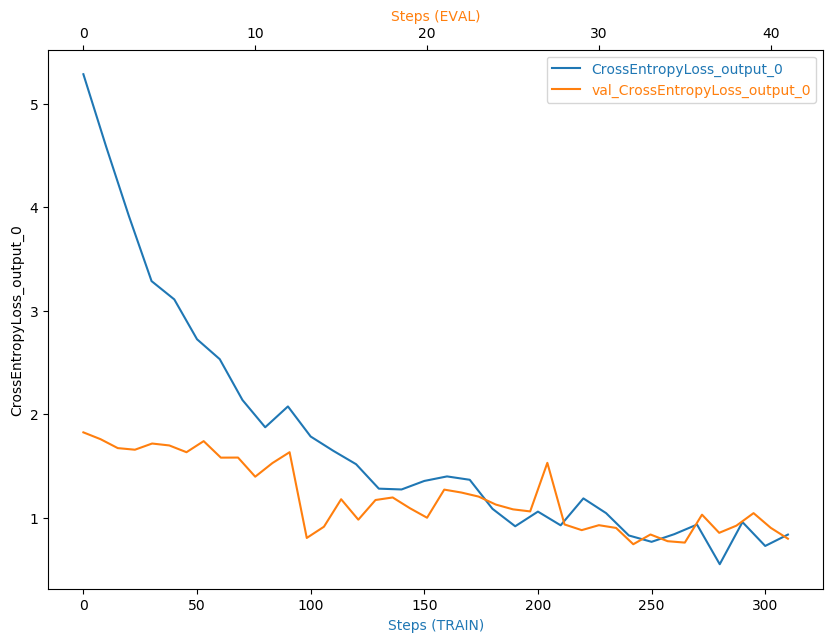

In [24]:
plot_tensor(trial,'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

We look for anomalous behaviour based on our specified rules. For example, rule_configs.overfit() detects if the model is being overfit to the training data. As stated in the [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html), a possible response is to regularize the model. Some techniques are presented [here](https://www.analyticsvidhya.com/blog/2021/05/complete-guide-to-regularization-techniques-in-machine-learning/#:~:text=of%20regularization%20techniques.-,What%20is%20Regularization%3F,the%20coefficient%20estimates%20towards%20zero).

In the chart above, we can see the loss function decreasing overall as steps go by. if this trend reversed, such as in this [reference](https://stats.stackexchange.com/questions/324896/training-loss-increases-with-time), we could consider decreasing the learning rate.

The frequency of rules getting triggered is summarised in the profiler report.

In [26]:
# Display profiler output
# Report saved to s3://sam-dl-project/train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/ProfilerReport/profiler-output/profiler-report.html

In [27]:
# Manually setting path to s3 report (with estimator not defined in notebook for this session)

rule_output_path = 's3://sam-dl-project/train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/'

! aws s3 ls {rule_output_path} --recursive

! aws s3 cp {rule_output_path} ./ --recursive

import IPython

IPython.display.HTML(filename="/root/course/deep-learning/project/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/ProfilerReport/profiler-output/profiler-report.html")

2023-01-03 13:15:21     375135 train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-01-03 13:15:20     223069 train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-01-03 13:15:15        192 train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-01-03 13:15:15        200 train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-01-03 13:15:15       1991 train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-01-03 13:15:15        127 train_model/pytorch-training-2023-01-03-12-41-26-709/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-01-03 13:15:15        199 train_model/pytorch-tra

## Model Deploying

In [3]:
# TODO: Deploy your model to an endpoint
import sagemaker

# Following these steps: https://knowledge.udacity.com/questions/775344
role = sagemaker.get_execution_role()
model_data = "s3://sam-dl-project/train_model/pytorch-training-2023-01-03-12-41-26-709/output/model.tar.gz"

In [4]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=model_data, role=role, entry_point='inference.py', framework_version="1.8", py_version="py36")

predictor = pytorch_model.deploy(instance_type="ml.t2.medium", initial_instance_count=1)

-------------!

In [5]:
# TODO: Run an prediction on the endpoint

# Using a random test image
# https://knowledge.udacity.com/questions/801129;
# https://learn.udacity.com/nanodegrees/nd189/parts/cd0386/lessons/c1e73645-0350-4b18-b788-d7832af74154/concepts/519d0cec-c830-4428-9bd8-394da9d84a98
from sagemaker.serializers import IdentitySerializer
from PIL import ImageFile
import s3fs

fs = s3fs.S3FileSystem()

predictor.serializer = IdentitySerializer("image/jpeg")
with fs.open("s3://sam-dl-project/input_data/test/126.Saint_bernard/Saint_bernard_08036.jpg", "rb") as f:
    payload = f.read()
    
response = predictor.predict(payload)

response

array([[ 0.0394279 , -0.08273524, -0.99565434,  2.68622327,  0.79257339,
         0.05036586,  2.838305  ,  0.80102772, -1.46139562,  1.64817524,
         2.88425469, -0.99146301, -0.65162373,  1.77849627,  1.56342232,
         1.53237844, -1.2617352 , -1.83383012,  1.44332087,  0.44738936,
        -0.836326  , -0.73167729, -1.79211307,  1.45453942,  0.11972097,
        -1.74741757,  0.8676942 ,  0.03243092, -1.44403529, -0.78370756,
         1.92871177,  0.33580732,  0.28131431,  0.93636549, -1.51598227,
        -2.79977322,  1.72500181, -0.1768976 ,  1.53000021,  1.08560479,
        -0.46484169,  0.06047413,  4.15723038, -1.45916498,  1.07581353,
        -1.63416564, -0.25015512,  1.83049393,  2.24792433, -0.17220479,
        -1.31164455, -0.55715787,  0.04970006, -0.52300394, -1.35312593,
        -1.10465825,  1.76616848, -1.38923728,  0.10285949,  0.83123451,
        -0.65143186,  0.67510915,  0.3818545 ,  0.2880052 , -0.99224067,
        -1.68447292,  1.15391421, -1.77868927,  1.4

In [8]:
# shutdown/delete your endpoint once work is done
predictor.delete_endpoint()